# Transformer Optimization

This notebook is based on chapter 8 **Making Transformers Efficient in Production** of the book **Natural Language Processing with Tranformers** and can be found [here](https://nbviewer.org/github/nlp-with-transformers/notebooks/blob/main/08_model-compression.ipynb).

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, pickle, sys, warnings, tqdm, time, torch, json, gzip
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import torch
from torch import nn
from torch.quantization import quantize_dynamic

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from transformers import pipeline, set_seed
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer
from datasets import load_dataset, load_metric

from benchmark import PerformanceBenchmark

## Functions

In [2]:
def plot_metrics(ax,perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT Baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()  

## Load Data

The dataset we are using is the `CLINC150` dataset for intent detection which can be found [here](https://huggingface.co/datasets/clinc_oos). This dataset includes 22,500 in-scope queries across 150 intents and 10 domains like banking and travel, and also includes 1,200 out-of-score queries that belong to `oos` intent class.

In [ ]:
clinc = load_dataset('clinc_oos', 'plus')

## Performance Benchmarks

### BERT Baseline

In [ ]:
%%time
optim_type='BERT Baseline'
pipe = pipeline('text-classification', model='transformersbook/bert-base-uncased-finetuned-clinc')
pb = PerformanceBenchmark(pipe, clinc['test'], optim_type=optim_type)

In [7]:
perf_metrics = pb.run_benchmark(clinc['test'].features['intent'])

Computing Accuracy:   0%|          | 0/5500 [00:00<?, ?it/s]

Accuracy on test set - 0.876
Average latency (ms) - 14.74 +\- 0.10
Model size (MB) - 132.40


### Making Models Smaller via Knowledge Distillation - DistilBERT

Knowledge distillation is a method for training a *smaller* student model to mimic the behavior of a slower, larger, but better-performing *teacher*.

Computing Accuracy:   0%|          | 0/5500 [00:00<?, ?it/s]

Accuracy on test set - 0.868
Average latency (ms) - 8.54 +\- 0.10
Model size (MB) - 255.89


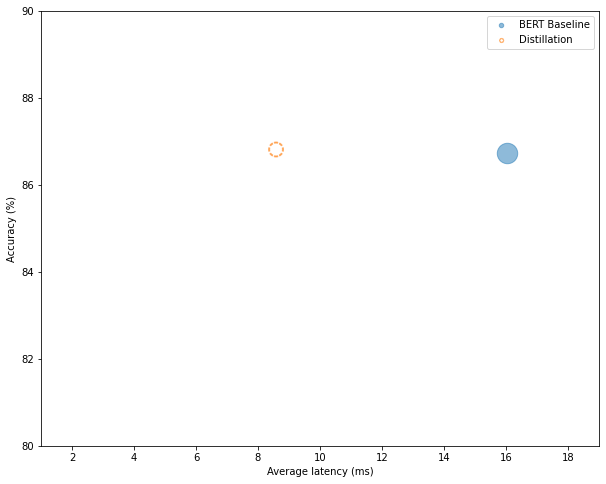

CPU times: user 29min 58s, sys: 4.82 s, total: 30min 3s
Wall time: 1min


In [5]:
%%time
optim_type='Distillation'
pipe = pipeline('text-classification', model='transformersbook/distilbert-base-uncased-distilled-clinc')
pb = PerformanceBenchmark(pipe, clinc['test'], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark(clinc['test'].features['intent']))

fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_metrics(ax, perf_metrics, optim_type)

### Making Models Faster with Quantization

Quantization makes computations much more efficient by representing weights and activations with low-precision data types like 8-bit integer instead of 32-bit floating point.

Computing Accuracy:   0%|          | 0/5500 [00:00<?, ?it/s]

Accuracy on test set - 0.876
Average latency (ms) - 14.98 +\- 0.70
Model size (MB) - 132.40


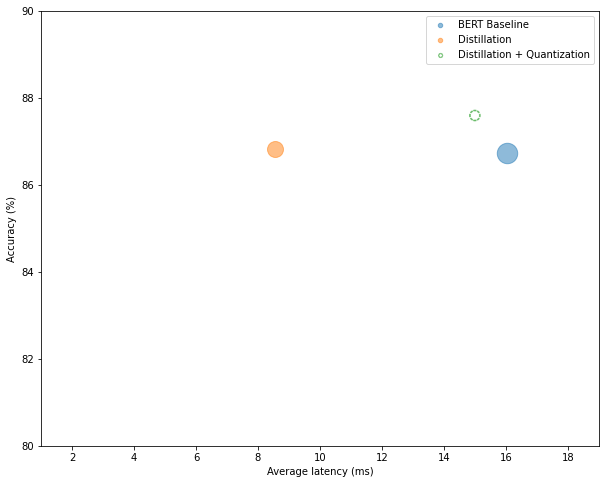

CPU times: user 39min 46s, sys: 5min 43s, total: 45min 30s
Wall time: 1min 29s


In [6]:
%%time
model_ckpt = 'transformersbook/distilbert-base-uncased-distilled-clinc'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt).to("cpu"))
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

optim_type='Distillation + Quantization'
pipe = pipeline('text-classification', model=model_quantized, tokenizer=tokenizer)
pb = PerformanceBenchmark(pipe, clinc['test'], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark(clinc['test'].features['intent']))

fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_metrics(ax, perf_metrics, optim_type)